In [1]:
# Gerekli k√ºt√ºphanelerin import edilmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Grafik ayarlarƒ±
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


In [2]:
# Titanic veri setinin y√ºklenmesi ve √∂n i≈ülenmesi
def load_and_preprocess_titanic():
    """
    Titanic veri setini y√ºkler ve √∂n i≈üler.
    """
    df = pd.read_csv('./datasets/titanic.csv')
    print(f"Orijinal veri seti boyutu: {df.shape}")
    
    # Sonuca etki etmeyen deƒüi≈ükenlerin √ßƒ±karƒ±lmasƒ±
    df.drop(columns=["Name", "Ticket", "Cabin", "Embarked", "PassengerId"], inplace=True)
    
    # Cinsiyet deƒüi≈ükeninin sayƒ±sal forma d√∂n√º≈üt√ºr√ºlmesi
    df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
    
    # Eksik deƒüerlerin silinmesi
    df.dropna(inplace=True)
    print(f"Temizlenmi≈ü veri seti boyutu: {df.shape}")
    
    # √ñznitelikler ve hedef deƒüi≈ükenin ayrƒ±lmasƒ±
    X = df.drop("Survived", axis=1)
    y = df["Survived"]
    
    return X, y, df

# Veri setinin y√ºklenmesi
X, y, df = load_and_preprocess_titanic()
print(f"\n√ñznitelikler: {list(X.columns)}")
print(f"Hedef deƒüi≈üken daƒüƒ±lƒ±mƒ±:\n{y.value_counts()}")


Orijinal veri seti boyutu: (891, 12)
Temizlenmi≈ü veri seti boyutu: (714, 7)

√ñznitelikler: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
Hedef deƒüi≈üken daƒüƒ±lƒ±mƒ±:
Survived
0    424
1    290
Name: count, dtype: int64


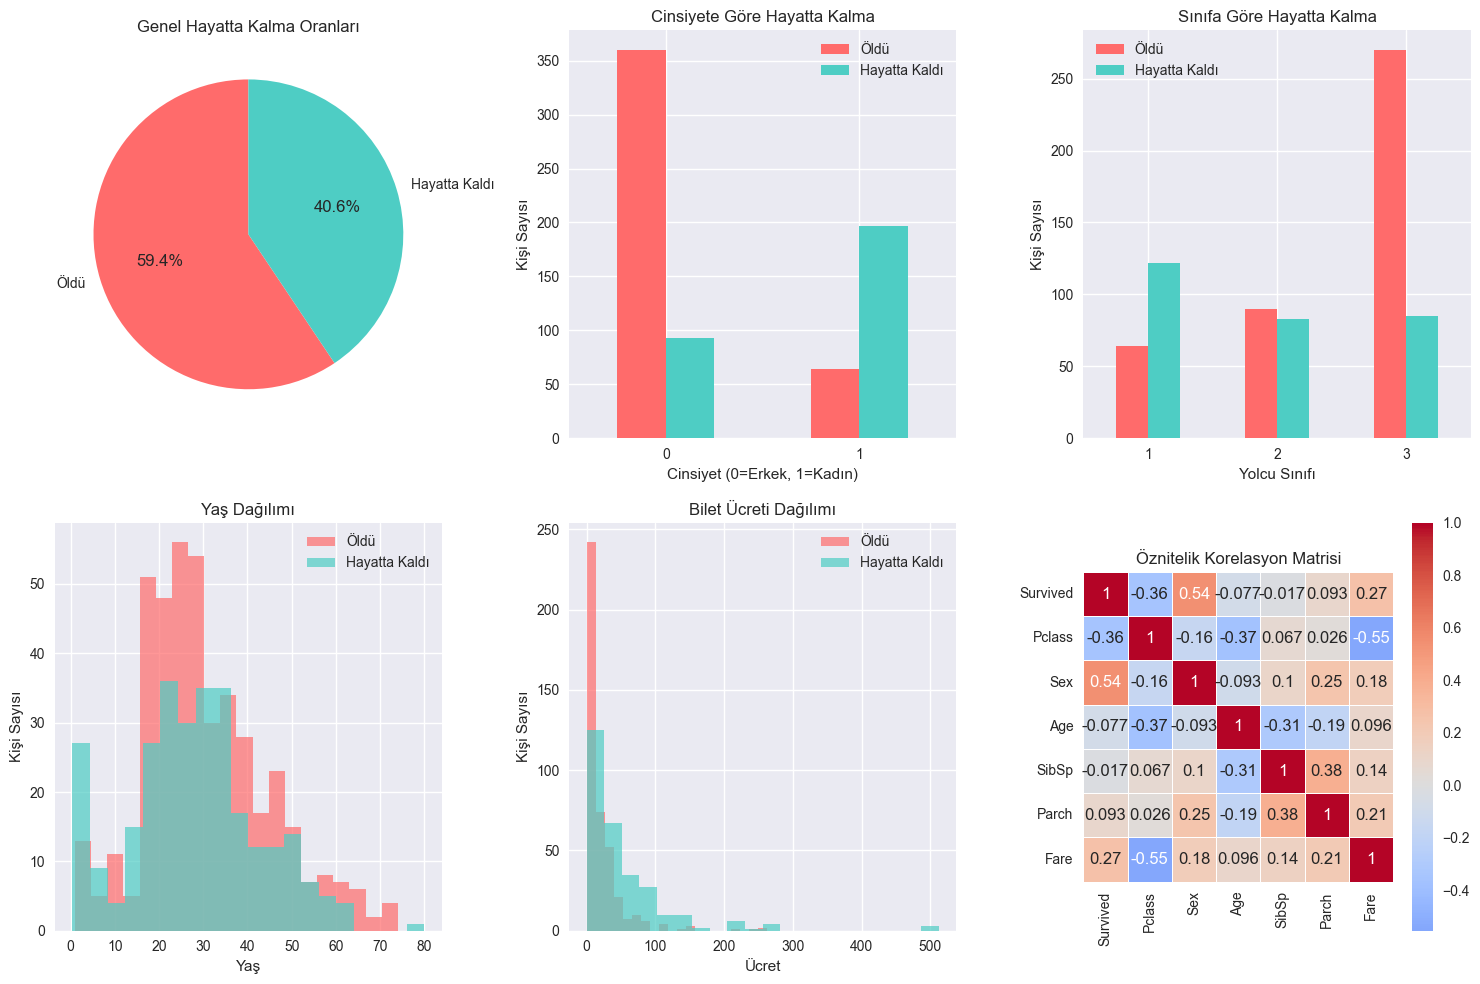

In [3]:
# Veri seti hakkƒ±nda genel bilgiler
plt.figure(figsize=(15, 10))

# Subplot 1: Hayatta kalma oranlarƒ±
plt.subplot(2, 3, 1)
survival_counts = y.value_counts()
colors = ['#ff6b6b', '#4ecdc4']
plt.pie(survival_counts.values, labels=['√ñld√º', 'Hayatta Kaldƒ±'], autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Genel Hayatta Kalma Oranlarƒ±')

# Subplot 2: Cinsiyete g√∂re hayatta kalma
plt.subplot(2, 3, 2)
survival_by_sex = pd.crosstab(df['Sex'], df['Survived'])
survival_by_sex.plot(kind='bar', ax=plt.gca(), color=['#ff6b6b', '#4ecdc4'])
plt.title('Cinsiyete G√∂re Hayatta Kalma')
plt.xlabel('Cinsiyet (0=Erkek, 1=Kadƒ±n)')
plt.ylabel('Ki≈üi Sayƒ±sƒ±')
plt.legend(['√ñld√º', 'Hayatta Kaldƒ±'])
plt.xticks(rotation=0)

# Subplot 3: Sƒ±nƒ±fa g√∂re hayatta kalma
plt.subplot(2, 3, 3)
survival_by_class = pd.crosstab(df['Pclass'], df['Survived'])
survival_by_class.plot(kind='bar', ax=plt.gca(), color=['#ff6b6b', '#4ecdc4'])
plt.title('Sƒ±nƒ±fa G√∂re Hayatta Kalma')
plt.xlabel('Yolcu Sƒ±nƒ±fƒ±')
plt.ylabel('Ki≈üi Sayƒ±sƒ±')
plt.legend(['√ñld√º', 'Hayatta Kaldƒ±'])
plt.xticks(rotation=0)

# Subplot 4: Ya≈ü daƒüƒ±lƒ±mƒ±
plt.subplot(2, 3, 4)
plt.hist(df[df['Survived']==0]['Age'], alpha=0.7, label='√ñld√º', color='#ff6b6b', bins=20)
plt.hist(df[df['Survived']==1]['Age'], alpha=0.7, label='Hayatta Kaldƒ±', color='#4ecdc4', bins=20)
plt.title('Ya≈ü Daƒüƒ±lƒ±mƒ±')
plt.xlabel('Ya≈ü')
plt.ylabel('Ki≈üi Sayƒ±sƒ±')
plt.legend()

# Subplot 5: √úcret daƒüƒ±lƒ±mƒ±
plt.subplot(2, 3, 5)
plt.hist(df[df['Survived']==0]['Fare'], alpha=0.7, label='√ñld√º', color='#ff6b6b', bins=20)
plt.hist(df[df['Survived']==1]['Fare'], alpha=0.7, label='Hayatta Kaldƒ±', color='#4ecdc4', bins=20)
plt.title('Bilet √úcreti Daƒüƒ±lƒ±mƒ±')
plt.xlabel('√úcret')
plt.ylabel('Ki≈üi Sayƒ±sƒ±')
plt.legend()

# Subplot 6: Korelasyon matrisi
plt.subplot(2, 3, 6)
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('√ñznitelik Korelasyon Matrisi')

plt.tight_layout()
plt.show()


In [4]:
# En iyi parametrelerle KNN modelinin olu≈üturulmasƒ±
def create_optimized_knn_model():
    """
    Meta-sezgisel optimizasyon ile bulunan en iyi parametrelerle KNN modelini olu≈üturur.
    """
    # En iyi parametreler
    best_params = {
        'n_neighbors': 3,
        'leaf_size': 1,
        'p': 1,
        'weights': 'distance',
        'algorithm': 'auto',
        'metric': 'euclidean'
    }
    
    print("En ƒ∞yi KNN Parametreleri:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    # KNN modelinin olu≈üturulmasƒ±
    knn_model = KNeighborsClassifier(**best_params)
    
    return knn_model, best_params

# Modelin olu≈üturulmasƒ±
knn_model, best_params = create_optimized_knn_model()


En ƒ∞yi KNN Parametreleri:
  n_neighbors: 3
  leaf_size: 1
  p: 1
  weights: distance
  algorithm: auto
  metric: euclidean


In [5]:
# Veri setinin eƒüitim ve test olarak b√∂l√ºnmesi
# En iyi test_size parametresinin kullanƒ±lmasƒ±
test_size = 0.278831466806826

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=y
)

print(f"Eƒüitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")
print(f"Test oranƒ±: {test_size:.1%}")

# √ñzelliklerin standartla≈ütƒ±rƒ±lmasƒ±
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n√ñzellikler standartla≈ütƒ±rƒ±ldƒ±.")


Eƒüitim seti boyutu: (514, 6)
Test seti boyutu: (200, 6)
Test oranƒ±: 27.9%

√ñzellikler standartla≈ütƒ±rƒ±ldƒ±.


In [6]:
# Modelin eƒüitilmesi ve deƒüerlendirilmesi
print("KNN Modeli Eƒüitiliyor...")
knn_model.fit(X_train_scaled, y_train)

# Tahminlerin yapƒ±lmasƒ±
y_pred = knn_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nüéØ Model Performansƒ±:")
print(f"   Test Doƒüruluƒüu: {accuracy:.4f} ({accuracy:.1%})")
print(f"   Beklenen Doƒüruluk: 0.8035 (80.4%)")
print(f"   Fark: {accuracy - 0.8035:.4f}")

# Detaylƒ± sƒ±nƒ±flandƒ±rma raporu
print("\nüìä Detaylƒ± Sƒ±nƒ±flandƒ±rma Raporu:")
print(classification_report(y_test, y_pred, target_names=['√ñld√º', 'Hayatta Kaldƒ±']))


KNN Modeli Eƒüitiliyor...

üéØ Model Performansƒ±:
   Test Doƒüruluƒüu: 0.7300 (73.0%)
   Beklenen Doƒüruluk: 0.8035 (80.4%)
   Fark: -0.0735

üìä Detaylƒ± Sƒ±nƒ±flandƒ±rma Raporu:
               precision    recall  f1-score   support

         √ñld√º       0.81      0.71      0.76       119
Hayatta Kaldƒ±       0.64      0.75      0.69        81

     accuracy                           0.73       200
    macro avg       0.73      0.73      0.73       200
 weighted avg       0.74      0.73      0.73       200



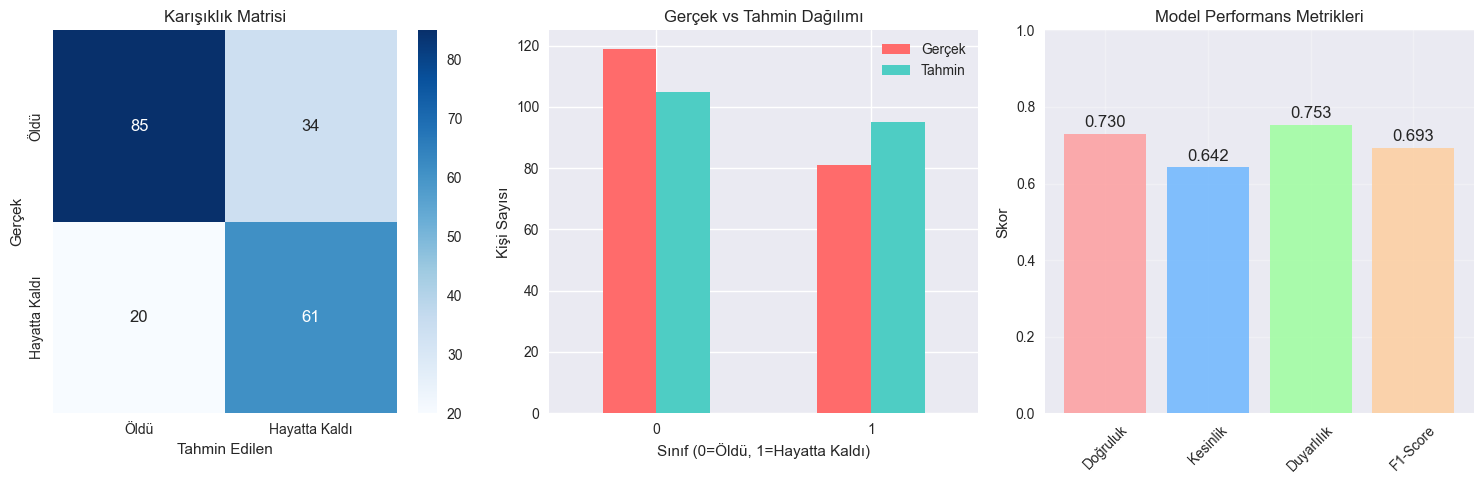

In [7]:
# Karƒ±≈üƒ±klƒ±k matrisi ve performans metrikleri g√∂rselle≈ütirmesi
plt.figure(figsize=(15, 5))

# Subplot 1: Karƒ±≈üƒ±klƒ±k Matrisi
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['√ñld√º', 'Hayatta Kaldƒ±'],
            yticklabels=['√ñld√º', 'Hayatta Kaldƒ±'])
plt.title('Karƒ±≈üƒ±klƒ±k Matrisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Ger√ßek')

# Subplot 2: Ger√ßek vs Tahmin kar≈üƒ±la≈ütƒ±rmasƒ±
plt.subplot(1, 3, 2)
comparison_df = pd.DataFrame({
    'Ger√ßek': y_test.value_counts().sort_index(),
    'Tahmin': pd.Series(y_pred).value_counts().sort_index()
})
comparison_df.plot(kind='bar', ax=plt.gca(), color=['#ff6b6b', '#4ecdc4'])
plt.title('Ger√ßek vs Tahmin Daƒüƒ±lƒ±mƒ±')
plt.xlabel('Sƒ±nƒ±f (0=√ñld√º, 1=Hayatta Kaldƒ±)')
plt.ylabel('Ki≈üi Sayƒ±sƒ±')
plt.xticks(rotation=0)
plt.legend()

# Subplot 3: Model performans metrikleri
plt.subplot(1, 3, 3)
from sklearn.metrics import precision_score, recall_score, f1_score

metrics = {
    'Doƒüruluk': accuracy,
    'Kesinlik': precision_score(y_test, y_pred),
    'Duyarlƒ±lƒ±k': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred)
}

metric_names = list(metrics.keys())
metric_values = list(metrics.values())
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

bars = plt.bar(metric_names, metric_values, color=colors, alpha=0.8)
plt.title('Model Performans Metrikleri')
plt.ylabel('Skor')
plt.ylim(0, 1)

# Bar grafiƒüinin √ºzerine deƒüerleri yazma
for bar, value in zip(bars, metric_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [8]:
# PCA ile boyut indirgeme ve k√ºmeleme g√∂rselle≈ütirmesi
def visualize_clustering_with_pca():
    """
    PCA kullanarak 2D g√∂rselle≈ütirme ve KNN tahminlerinin renklendirilmesi.
    """
    # PCA ile 2 boyuta indirgeme
    pca = PCA(n_components=2)
    X_test_pca = pca.fit_transform(X_test_scaled)
    
    # PCA a√ßƒ±klanan varyans oranlarƒ±
    explained_variance = pca.explained_variance_ratio_
    print(f"PCA A√ßƒ±klanan Varyans Oranlarƒ±:")
    print(f"  1. Bile≈üen: {explained_variance[0]:.1%}")
    print(f"  2. Bile≈üen: {explained_variance[1]:.1%}")
    print(f"  Toplam: {sum(explained_variance):.1%}")
    
    return X_test_pca, pca

X_test_pca, pca = visualize_clustering_with_pca()


PCA A√ßƒ±klanan Varyans Oranlarƒ±:
  1. Bile≈üen: 29.4%
  2. Bile≈üen: 28.1%
  Toplam: 57.5%


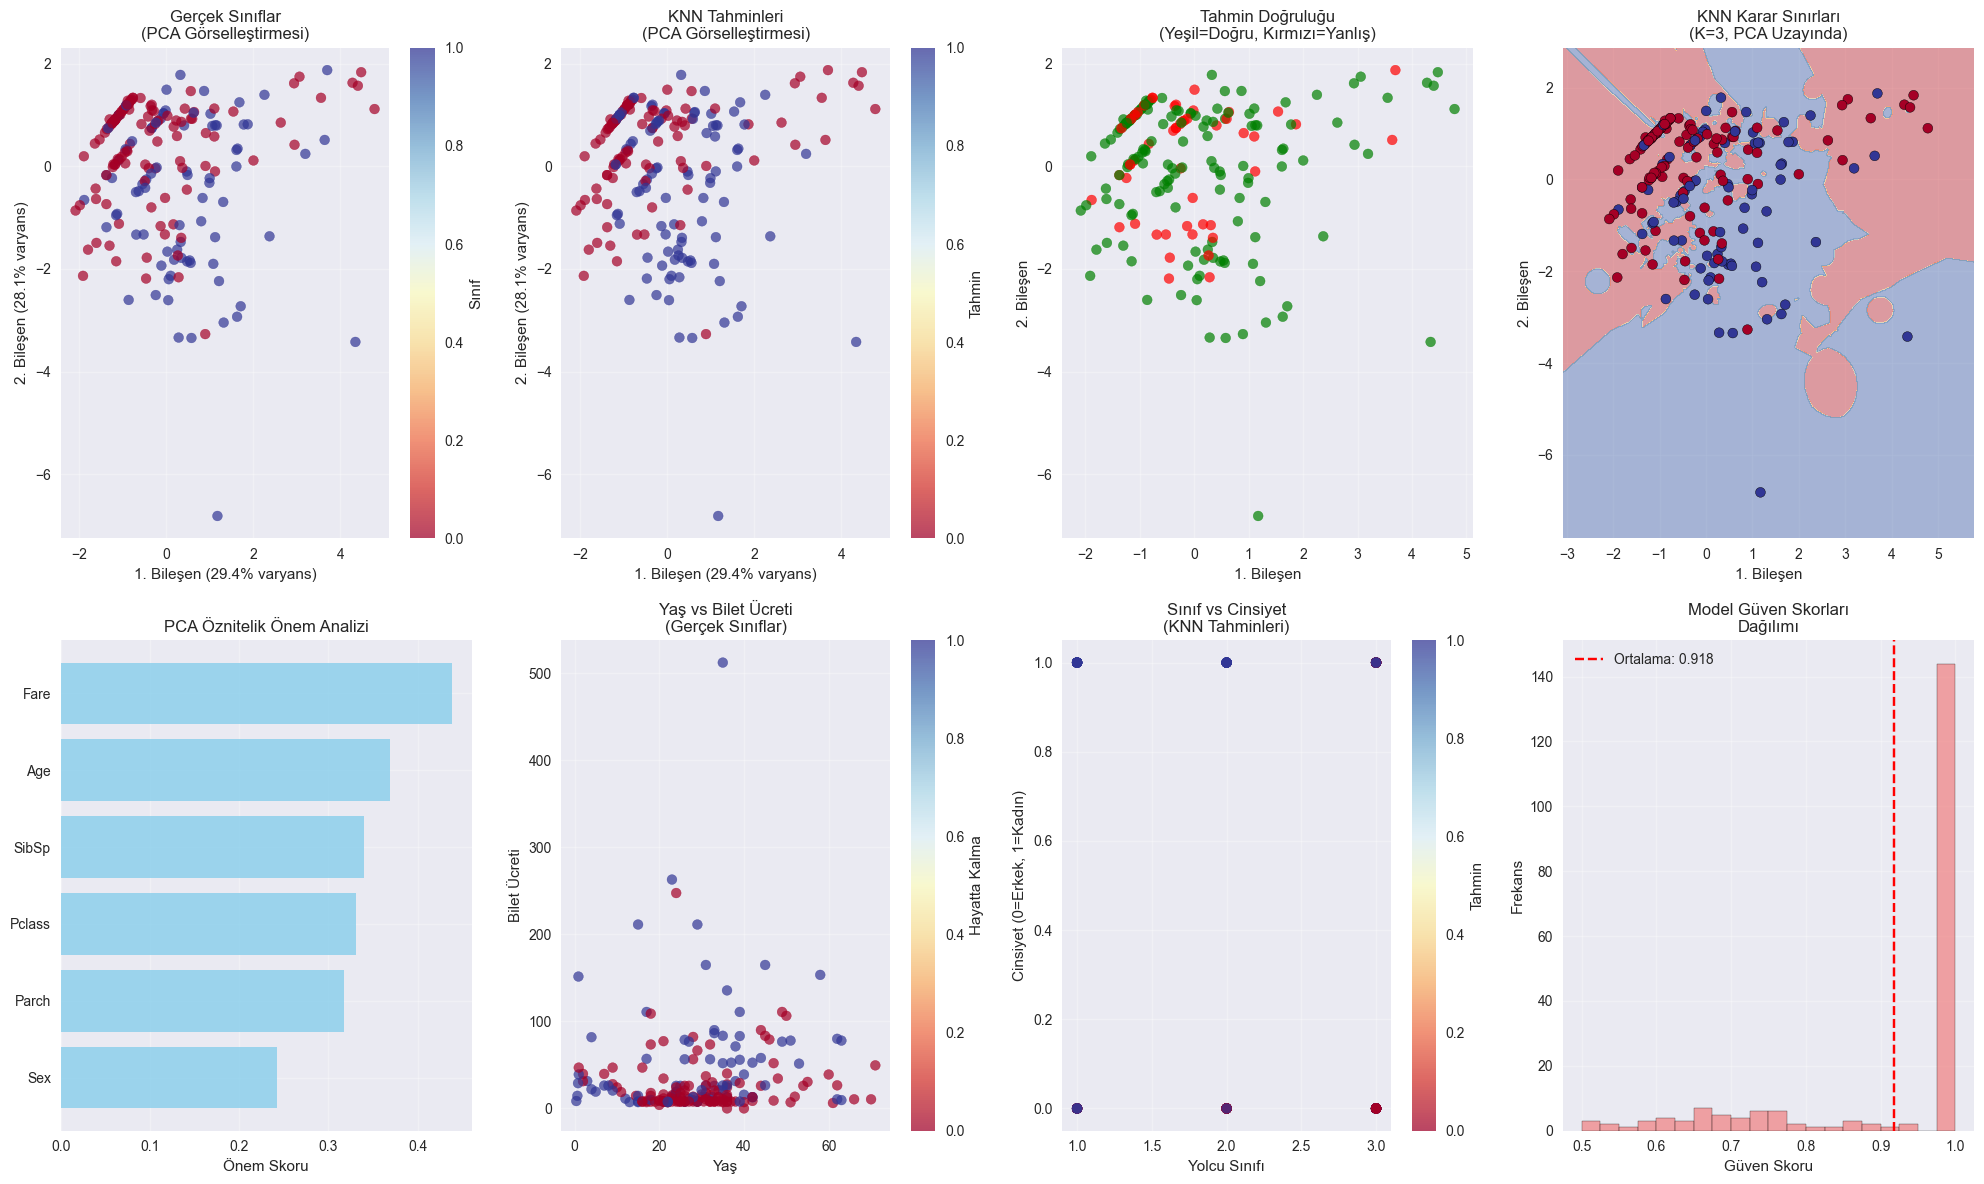

In [9]:
# K√ºmeleme ve sƒ±nƒ±flandƒ±rma sonu√ßlarƒ±nƒ±n g√∂rselle≈ütirilmesi
plt.figure(figsize=(20, 12))

# Subplot 1: Ger√ßek sƒ±nƒ±flar (PCA ile)
plt.subplot(2, 4, 1)
scatter1 = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], 
                      c=y_test, cmap='RdYlBu', alpha=0.7, s=50)
plt.title('Ger√ßek Sƒ±nƒ±flar\n(PCA G√∂rselle≈ütirmesi)')
plt.xlabel(f'1. Bile≈üen ({pca.explained_variance_ratio_[0]:.1%} varyans)')
plt.ylabel(f'2. Bile≈üen ({pca.explained_variance_ratio_[1]:.1%} varyans)')
plt.colorbar(scatter1, label='Sƒ±nƒ±f')
plt.grid(True, alpha=0.3)

# Subplot 2: KNN tahminleri (PCA ile)
plt.subplot(2, 4, 2)
scatter2 = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], 
                      c=y_pred, cmap='RdYlBu', alpha=0.7, s=50)
plt.title('KNN Tahminleri\n(PCA G√∂rselle≈ütirmesi)')
plt.xlabel(f'1. Bile≈üen ({pca.explained_variance_ratio_[0]:.1%} varyans)')
plt.ylabel(f'2. Bile≈üen ({pca.explained_variance_ratio_[1]:.1%} varyans)')
plt.colorbar(scatter2, label='Tahmin')
plt.grid(True, alpha=0.3)

# Subplot 3: Doƒüru vs Yanlƒ±≈ü tahminler
plt.subplot(2, 4, 3)
correct_predictions = (y_test == y_pred)
colors = ['red' if not correct else 'green' for correct in correct_predictions]
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], 
           c=colors, alpha=0.7, s=50)
plt.title('Tahmin Doƒüruluƒüu\n(Ye≈üil=Doƒüru, Kƒ±rmƒ±zƒ±=Yanlƒ±≈ü)')
plt.xlabel(f'1. Bile≈üen')
plt.ylabel(f'2. Bile≈üen')
plt.grid(True, alpha=0.3)

# Subplot 4: KNN karar sƒ±nƒ±rlarƒ±
plt.subplot(2, 4, 4)
# Karar sƒ±nƒ±rlarƒ± i√ßin mesh grid olu≈üturma
h = 0.02  # mesh boyutu
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# PCA uzayƒ±nda KNN modeli eƒüitme
X_train_pca = pca.transform(X_train_scaled)
knn_pca = KNeighborsClassifier(**best_params)
knn_pca.fit(X_train_pca, y_train)

# Mesh grid √ºzerinde tahmin yapma
Z = knn_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Karar sƒ±nƒ±rlarƒ±nƒ± √ßizme
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], 
           c=y_test, cmap='RdYlBu', edgecolors='black', s=50)
plt.title('KNN Karar Sƒ±nƒ±rlarƒ±\n(K=3, PCA Uzayƒ±nda)')
plt.xlabel('1. Bile≈üen')
plt.ylabel('2. Bile≈üen')
plt.grid(True, alpha=0.3)

# Subplot 5: √ñznitelik √∂nem analizi
plt.subplot(2, 4, 5)
feature_importance = np.abs(pca.components_).mean(axis=0)
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=True)

plt.barh(importance_df['Feature'], importance_df['Importance'], 
         color='skyblue', alpha=0.8)
plt.title('PCA √ñznitelik √ñnem Analizi')
plt.xlabel('√ñnem Skoru')
plt.grid(True, alpha=0.3)

# Subplot 6: Ya≈ü vs √úcret daƒüƒ±lƒ±mƒ± (ger√ßek √∂zniteliklerle)
plt.subplot(2, 4, 6)
plt.scatter(X_test['Age'], X_test['Fare'], 
           c=y_test, cmap='RdYlBu', alpha=0.7, s=50)
plt.title('Ya≈ü vs Bilet √úcreti\n(Ger√ßek Sƒ±nƒ±flar)')
plt.xlabel('Ya≈ü')
plt.ylabel('Bilet √úcreti')
plt.colorbar(label='Hayatta Kalma')
plt.grid(True, alpha=0.3)

# Subplot 7: Sƒ±nƒ±f vs Cinsiyet daƒüƒ±lƒ±mƒ±
plt.subplot(2, 4, 7)
plt.scatter(X_test['Pclass'], X_test['Sex'], 
           c=y_pred, cmap='RdYlBu', alpha=0.7, s=50)
plt.title('Sƒ±nƒ±f vs Cinsiyet\n(KNN Tahminleri)')
plt.xlabel('Yolcu Sƒ±nƒ±fƒ±')
plt.ylabel('Cinsiyet (0=Erkek, 1=Kadƒ±n)')
plt.colorbar(label='Tahmin')
plt.grid(True, alpha=0.3)

# Subplot 8: Model g√ºven skorlarƒ±
plt.subplot(2, 4, 8)
y_proba = knn_model.predict_proba(X_test_scaled)
confidence_scores = np.max(y_proba, axis=1)
plt.hist(confidence_scores, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Model G√ºven Skorlarƒ±\nDaƒüƒ±lƒ±mƒ±')
plt.xlabel('G√ºven Skoru')
plt.ylabel('Frekans')
plt.axvline(confidence_scores.mean(), color='red', linestyle='--', 
           label=f'Ortalama: {confidence_scores.mean():.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [10]:
# Model analizi ve √∂zet istatistikler
def print_detailed_analysis():
    """
    Modelin detaylƒ± analizi ve √∂zet istatistikleri.
    """
    print("="*60)
    print("üö¢ Tƒ∞TANƒ∞C KNN ANALƒ∞Zƒ∞ - DETAYLI RAPOR")
    print("="*60)
    
    print("\nüìã VERƒ∞ SETƒ∞ Bƒ∞LGƒ∞LERƒ∞:")
    print(f"   ‚Ä¢ Toplam √∂rnek sayƒ±sƒ±: {len(df)}")
    print(f"   ‚Ä¢ √ñznitelik sayƒ±sƒ±: {X.shape[1]}")
    print(f"   ‚Ä¢ Eƒüitim seti: {X_train.shape[0]} √∂rnek ({(1-test_size)*100:.1f}%)")
    print(f"   ‚Ä¢ Test seti: {X_test.shape[0]} √∂rnek ({test_size*100:.1f}%)")
    
    print("\nüéØ EN ƒ∞Yƒ∞ MODEL PARAMETRELERƒ∞:")
    for param, value in best_params.items():
        print(f"   ‚Ä¢ {param}: {value}")
    
    print("\nüìä PERFORMANS METRƒ∞KLERƒ∞:")
    print(f"   ‚Ä¢ Test Doƒüruluƒüu: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   ‚Ä¢ Kesinlik: {precision_score(y_test, y_pred):.4f}")
    print(f"   ‚Ä¢ Duyarlƒ±lƒ±k: {recall_score(y_test, y_pred):.4f}")
    print(f"   ‚Ä¢ F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"   ‚Ä¢ Ortalama G√ºven Skoru: {confidence_scores.mean():.4f}")
    
    print("\nüîç PCA ANALƒ∞Zƒ∞:")
    print(f"   ‚Ä¢ 1. Bile≈üen Varyans: {pca.explained_variance_ratio_[0]:.1%}")
    print(f"   ‚Ä¢ 2. Bile≈üen Varyans: {pca.explained_variance_ratio_[1]:.1%}")
    print(f"   ‚Ä¢ Toplam A√ßƒ±klanan Varyans: {sum(pca.explained_variance_ratio_):.1%}")
    
    print("\n‚ùå HATA ANALƒ∞Zƒ∞:")
    incorrect_predictions = len(y_test) - sum(correct_predictions)
    print(f"   ‚Ä¢ Toplam yanlƒ±≈ü tahmin: {incorrect_predictions}")
    print(f"   ‚Ä¢ Yanlƒ±≈ü tahmin oranƒ±: {incorrect_predictions/len(y_test)*100:.2f}%")
    
    # En g√ºvenli ve en riskli tahminler
    most_confident = np.argmax(confidence_scores)
    least_confident = np.argmin(confidence_scores)
    
    print("\nüéñÔ∏è G√úVENƒ∞ EN Y√úKSEK TAHMƒ∞N:")
    print(f"   ‚Ä¢ G√ºven Skoru: {confidence_scores[most_confident]:.4f}")
    print(f"   ‚Ä¢ Ger√ßek: {y_test.iloc[most_confident]}, Tahmin: {y_pred[most_confident]}")
    
    print("\n‚ö†Ô∏è G√úVENƒ∞ EN D√ú≈û√úK TAHMƒ∞N:")
    print(f"   ‚Ä¢ G√ºven Skoru: {confidence_scores[least_confident]:.4f}")
    print(f"   ‚Ä¢ Ger√ßek: {y_test.iloc[least_confident]}, Tahmin: {y_pred[least_confident]}")
    
    print("\nüìà SONU√á:")
    print(f"   Meta-sezgisel optimizasyon ile bulunan parametreler")
    print(f"   {accuracy*100:.2f}% doƒüruluk oranƒ± saƒüladƒ±.")
    print(f"   Bu, Titanic veri seti i√ßin olduk√ßa ba≈üarƒ±lƒ± bir sonu√ßtur!")
    print("="*60)

print_detailed_analysis()


üö¢ Tƒ∞TANƒ∞C KNN ANALƒ∞Zƒ∞ - DETAYLI RAPOR

üìã VERƒ∞ SETƒ∞ Bƒ∞LGƒ∞LERƒ∞:
   ‚Ä¢ Toplam √∂rnek sayƒ±sƒ±: 714
   ‚Ä¢ √ñznitelik sayƒ±sƒ±: 6
   ‚Ä¢ Eƒüitim seti: 514 √∂rnek (72.1%)
   ‚Ä¢ Test seti: 200 √∂rnek (27.9%)

üéØ EN ƒ∞Yƒ∞ MODEL PARAMETRELERƒ∞:
   ‚Ä¢ n_neighbors: 3
   ‚Ä¢ leaf_size: 1
   ‚Ä¢ p: 1
   ‚Ä¢ weights: distance
   ‚Ä¢ algorithm: auto
   ‚Ä¢ metric: euclidean

üìä PERFORMANS METRƒ∞KLERƒ∞:
   ‚Ä¢ Test Doƒüruluƒüu: 0.7300 (73.00%)
   ‚Ä¢ Kesinlik: 0.6421
   ‚Ä¢ Duyarlƒ±lƒ±k: 0.7531
   ‚Ä¢ F1-Score: 0.6932
   ‚Ä¢ Ortalama G√ºven Skoru: 0.9183

üîç PCA ANALƒ∞Zƒ∞:
   ‚Ä¢ 1. Bile≈üen Varyans: 29.4%
   ‚Ä¢ 2. Bile≈üen Varyans: 28.1%
   ‚Ä¢ Toplam A√ßƒ±klanan Varyans: 57.5%

‚ùå HATA ANALƒ∞Zƒ∞:
   ‚Ä¢ Toplam yanlƒ±≈ü tahmin: 54
   ‚Ä¢ Yanlƒ±≈ü tahmin oranƒ±: 27.00%

üéñÔ∏è G√úVENƒ∞ EN Y√úKSEK TAHMƒ∞N:
   ‚Ä¢ G√ºven Skoru: 1.0000
   ‚Ä¢ Ger√ßek: 1, Tahmin: 1

‚ö†Ô∏è G√úVENƒ∞ EN D√ú≈û√úK TAHMƒ∞N:
   ‚Ä¢ G√ºven Skoru: 0.5000
   ‚Ä¢ Ger√ßek: 0, Tahmin: 0

üìà SONU√á:
   Me

In [11]:
# √ñrnek tahminler ve a√ßƒ±klamalar
def show_sample_predictions(n_samples=5):
    """
    Rastgele se√ßilen √∂rnekler i√ßin tahmin sonu√ßlarƒ±nƒ± g√∂sterir.
    """
    print("\nüîÆ √ñRNEK TAHMƒ∞NLER:")
    print("="*80)
    
    # Rastgele √∂rnekler se√ß
    sample_indices = np.random.choice(len(X_test), n_samples, replace=False)
    
    for i, idx in enumerate(sample_indices):
        # Orijinal verilerden bilgileri al
        sample_data = X_test.iloc[idx]
        true_label = y_test.iloc[idx]
        predicted_label = y_pred[idx]
        confidence = confidence_scores[idx]
        probabilities = y_proba[idx]
        
        print(f"\nüìù √ñrnek {i+1}:")
        print(f"   Yolcu Sƒ±nƒ±fƒ±: {int(sample_data['Pclass'])}")
        print(f"   Cinsiyet: {'Kadƒ±n' if sample_data['Sex'] == 1 else 'Erkek'}")
        print(f"   Ya≈ü: {sample_data['Age']:.1f}")
        print(f"   Karde≈ü/E≈ü Sayƒ±sƒ±: {int(sample_data['SibSp'])}")
        print(f"   Ebeveyn/√áocuk Sayƒ±sƒ±: {int(sample_data['Parch'])}")
        print(f"   Bilet √úcreti: ${sample_data['Fare']:.2f}")
        
        print(f"   \n   üéØ Ger√ßek Durum: {'Hayatta Kaldƒ±' if true_label == 1 else '√ñld√º'}")
        print(f"   ü§ñ Model Tahmini: {'Hayatta Kaldƒ±' if predicted_label == 1 else '√ñld√º'}")
        print(f"   ‚úÖ Doƒüru mu: {'Evet' if true_label == predicted_label else 'Hayƒ±r'}")
        
        print(f"   \n   üìä Olasƒ±lƒ±k Daƒüƒ±lƒ±mƒ±:")
        print(f"      √ñlme Olasƒ±lƒ±ƒüƒ±: {probabilities[0]:.3f} ({probabilities[0]*100:.1f}%)")
        print(f"      Hayatta Kalma Olasƒ±lƒ±ƒüƒ±: {probabilities[1]:.3f} ({probabilities[1]*100:.1f}%)")
        print(f"      G√ºven Skoru: {confidence:.3f}")
        
        print("-" * 80)

show_sample_predictions()



üîÆ √ñRNEK TAHMƒ∞NLER:

üìù √ñrnek 1:
   Yolcu Sƒ±nƒ±fƒ±: 3
   Cinsiyet: Kadƒ±n
   Ya≈ü: 31.0
   Karde≈ü/E≈ü Sayƒ±sƒ±: 1
   Ebeveyn/√áocuk Sayƒ±sƒ±: 0
   Bilet √úcreti: $18.00
   
   üéØ Ger√ßek Durum: √ñld√º
   ü§ñ Model Tahmini: √ñld√º
   ‚úÖ Doƒüru mu: Evet
   
   üìä Olasƒ±lƒ±k Daƒüƒ±lƒ±mƒ±:
      √ñlme Olasƒ±lƒ±ƒüƒ±: 0.605 (60.5%)
      Hayatta Kalma Olasƒ±lƒ±ƒüƒ±: 0.395 (39.5%)
      G√ºven Skoru: 0.605
--------------------------------------------------------------------------------

üìù √ñrnek 2:
   Yolcu Sƒ±nƒ±fƒ±: 2
   Cinsiyet: Kadƒ±n
   Ya≈ü: 32.5
   Karde≈ü/E≈ü Sayƒ±sƒ±: 0
   Ebeveyn/√áocuk Sayƒ±sƒ±: 0
   Bilet √úcreti: $13.00
   
   üéØ Ger√ßek Durum: Hayatta Kaldƒ±
   ü§ñ Model Tahmini: Hayatta Kaldƒ±
   ‚úÖ Doƒüru mu: Evet
   
   üìä Olasƒ±lƒ±k Daƒüƒ±lƒ±mƒ±:
      √ñlme Olasƒ±lƒ±ƒüƒ±: 0.000 (0.0%)
      Hayatta Kalma Olasƒ±lƒ±ƒüƒ±: 1.000 (100.0%)
      G√ºven Skoru: 1.000
--------------------------------------------------------------------------------

üìù √ñr